# Credit Scoring

Для выполнения этого задания вам понадобятся данные о кредитных историях клиентов одного из банков. Поля в предоставляемых данных имеют следующий смысл: 

   - LIMIT_BAL:  размер кредитного лимита (в том числе и на семью клиента)
   - SEX: пол клиента (1 = мужской, 2 = женский )
   - EDUCATION: образование (0 = доктор, 1 = магистр; 2 = бакалавр; 3 = выпускник школы; 4 = начальное образование; 5= прочее; 6 = нет данных ).
   - MARRIAGE: (0 = отказываюсь отвечать; 1 = замужем/женат; 2 = холост; 3 = нет данных). 
   - AGE: возраст в годах
   - PAY_0 - PAY_6 : История прошлых платежей по кредиту. PAY_6 - платеж в апреле, ... Pay_0 - платеж в сентябре. Платеж = (0 = исправный платеж, 1=задержка в один месяц, 2=задержка в 2 месяца ...)
   - BILL_AMT1 - BILL_AMT6:  задолженность,  BILL_AMT6 - на апрель, BILL_AMT1 - на сентябрь 
   - PAY_AMT1 - PAY_AMT6: сумма уплаченная в PAY_AMT6 - апреле, ..., PAY_AMT1 - сентябре     - default - индикатор невозврата денежных средств

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import statsmodels
import scipy as sc
import numpy as np
import pandas as pd
import statsmodels.stats.multitest as smm
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
from statsmodels.graphics.regressionplots import plot_leverage_resid2
from statsmodels.stats.proportion import proportion_confint
from statsmodels.stats.weightstats import *
import matplotlib.pyplot as plt

In [4]:
print(np.__version__)
print(pd.__version__)
print(sc.__version__)
print(statsmodels.__version__)

1.19.2
1.2.1
1.5.2
0.12.1


In [5]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [6]:
data = pd.read_csv('credit_card_default_analysis.csv', sep=',')
data.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,1,20000,2,2,1,24,2,2,0,0,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,0,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,0,0,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [7]:
data.shape

(30000, 25)

## Задание 1

Размер кредитного лимита (LIMIT_BAL). В двух группах, тех людей, кто вернул кредит (default = 0) и тех, кто его не вернул (default = 1) проверьте гипотезы:   a)  о равенстве медианных значений кредитного лимита с помощью подходящей интервальной оценки  b) о равенстве распределений с помощью одного из подходящих непараметрических критериев проверки равенства средних.  Значимы ли полученные результаты с практической точки зрения ?

In [59]:
limit_default = data[data['default'] == 1].LIMIT_BAL
# limit_default

In [60]:
limit_no_default = data[data['default'] == 0].LIMIT_BAL
# limit_no_default

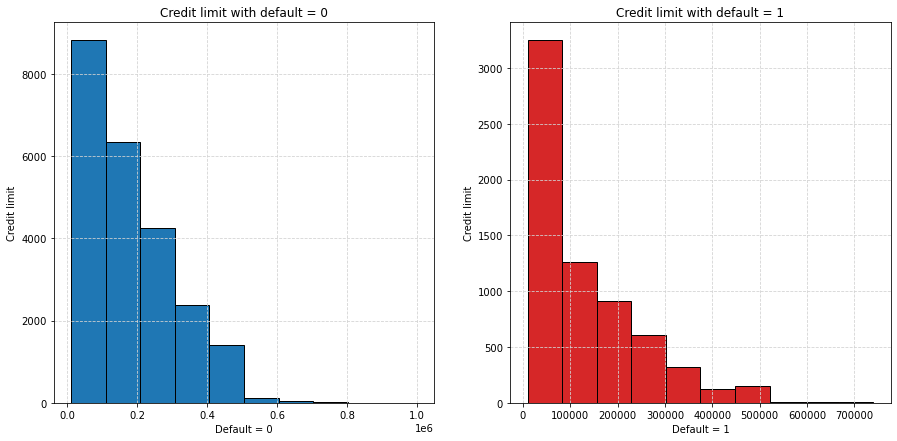

In [47]:
pylab.figure(figsize=(15,7))

pylab.subplot(1,2,1)
pylab.grid(color='lightgrey', linestyle='--')
pylab.hist(limit_no_default.values, color ='tab:blue',  edgecolor='k')
pylab.xlabel('Default = 0')
pylab.ylabel('Credit limit')
pylab.title('Credit limit with default = 0')

pylab.subplot(1,2,2)
pylab.grid(color='lightgrey', linestyle='--')
pylab.hist(limit_default.values, color = 'tab:red', edgecolor='k')
pylab.xlabel('Default = 1')
pylab.ylabel('Credit limit')
pylab.title('Credit limit with default = 1')

pylab.show()

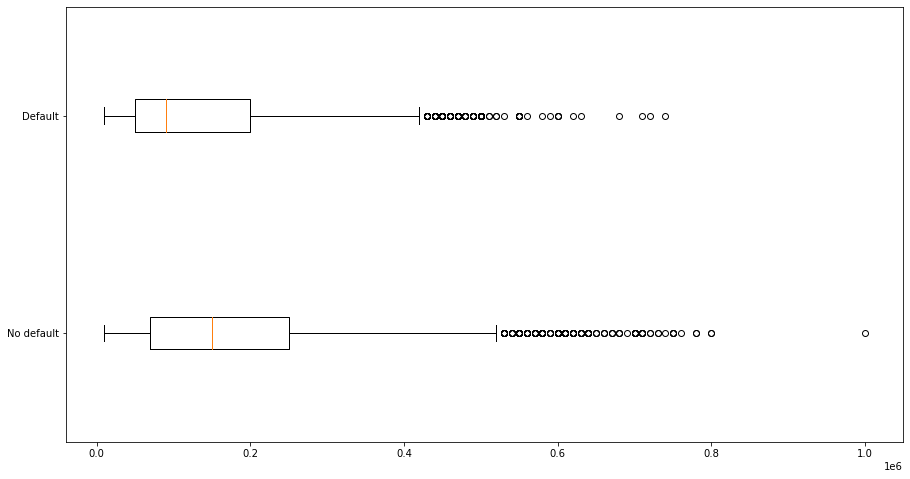

In [77]:
pylab.figure(figsize=(15,8))
pylab.boxplot([limit_no_default.values,limit_default.values], vert=False, labels=["No default", "Default"])
pylab.show()

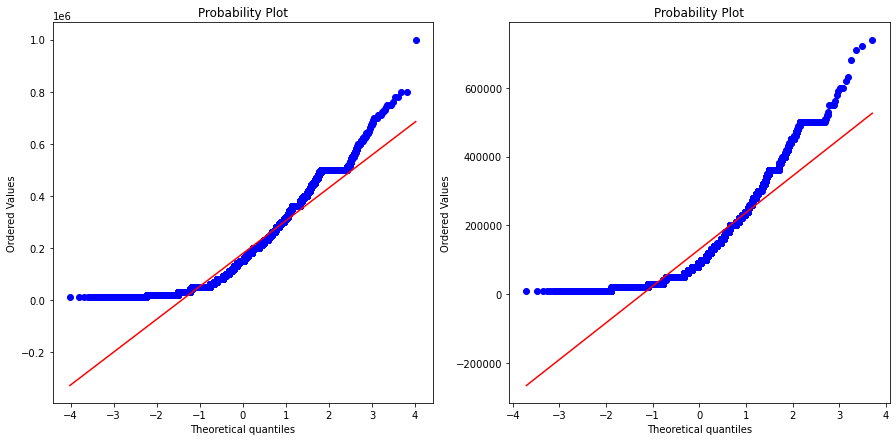

In [84]:
pylab.figure(figsize=(15,7))

pylab.subplot(1,2,1)
sc.stats.probplot(limit_no_default.values, dist="norm", plot=pylab)
pylab.subplot(1,2,2)
sc.stats.probplot(limit_default.values, dist="norm", plot=pylab)

pylab.show()

In [85]:
print("Shapiro-Wilk normality test, W-statistic: %f, p-value: %f" % sc.stats.shapiro(limit_no_default.values))

Shapiro-Wilk normality test, W-statistic: 0.919726, p-value: 0.000000


In [86]:
print("Shapiro-Wilk normality test, W-statistic: %f, p-value: %f" % sc.stats.shapiro(limit_default.values))

Shapiro-Wilk normality test, W-statistic: 0.854983, p-value: 0.000000



Q-Q plot и графики распределения подтверждают, что мы имеем дело с двумя выборками, которые имеют не нормальное распределение. Также мы можем сделать вывод о том, что кредитный лимит значительно выше для категории default = 0. Нулевую гипотезу о нормальности распределений отвергает и критерий Шапиро-Уилка.

Так как выборки не имеют нормального распределения мы не можеи использовать параметрические критерии для распределений Стьюдента и тд. Для этой задачи может подойти использование критерия Манна-Уитни, перестановочный критерий или бутсрап.


Тогда мы расматриваем такие гипотезы:

$H_{0}: med(X_{1}) = med(X_{2})) $

$H_{0} = med(X_{1})\neq med(X_{2})) $

In [49]:
print('Credit limit median for default = 0: {}'.format(limit_no_default.median()))
print('Credit limit median for default = 1: {}'.format(limit_default.median()))

Credit limit median for default = 0: 150000.0
Credit limit median for default = 1: 90000.0


### Непараметрические критерии равенства средних: критерий Манна-Уитни

In [82]:
print('Критерий Манна-Уитни для двухвыборочной задачи с независимыми выборками: {}'.format(sc.stats.mannwhitneyu(limit_no_default,limit_default)))


Критерий Манна-Уитни для двухвыборочной задачи с независимыми выборками: MannwhitneyuResult(statistic=59257217.5, pvalue=6.127742909111652e-190)


### Непараметрические критерии равенства средних: перестановочный критерий для независимых выборок

$H_0\colon F_{X_1}(x) = F_{X_2}(x)$

$H_1\colon F_{X_1}(x) = F_{X_2}(x + \Delta), \Delta\neq 0$

In [87]:
def permutation_t_stat_ind(sample1, sample2):
    return np.mean(sample1) - np.mean(sample2)

In [92]:
def get_random_combinations(n1, n2, max_combinations):
    index = list(range(n1 + n2))
    indices = set([tuple(index)])
    for i in range(max_combinations - 1):
        np.random.shuffle(index)
        indices.add(tuple(index))
    return [(index[:n1], index[n1:]) for index in indices]

In [89]:
def permutation_zero_dist_ind(sample1, sample2, max_combinations = None):
    joined_sample = np.hstack((sample1, sample2))
    n1 = len(sample1)
    n = len(joined_sample)
    
    if max_combinations:
        indices = get_random_combinations(n1, len(sample2), max_combinations)
    else:
        indices = [(list(index), filter(lambda i: i not in index, range(n))) \
                    for index in itertools.combinations(range(n), n1)]
    
    distr = [joined_sample[list(i[0])].mean() - joined_sample[list(i[1])].mean() \
             for i in indices]
    return distr

In [90]:
def permutation_test(sample, mean, max_permutations = None, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    t_stat = permutation_t_stat_ind(sample, mean)
    
    zero_distr = permutation_zero_dist_ind(sample, mean, max_permutations)
    
    if alternative == 'two-sided':
        return sum([1. if abs(x) >= abs(t_stat) else 0. for x in zero_distr]) / len(zero_distr)
    
    if alternative == 'less':
        return sum([1. if x <= t_stat else 0. for x in zero_distr]) / len(zero_distr)

    if alternative == 'greater':
        return sum([1. if x >= t_stat else 0. for x in zero_distr]) / len(zero_distr)

In [93]:
print ("p-value: %f" % permutation_test(limit_no_default, limit_default, max_permutations = 10000))

p-value: 0.000100


### Непараметрические критерии равенства средних: бутстреп

In [94]:
def get_bootstrap_samples(data, n_samples):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

In [95]:
def stat_intervals(stat, alpha):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

In [100]:
np.random.seed(0)

limit_default_bootstrap = get_bootstrap_samples(limit_default.values,n_samples=1000)
limit_default_boot_median = np.median(limit_default_bootstrap, axis=0)

limit_no_default_bootstrap = get_bootstrap_samples(limit_no_default.values,n_samples=1000)
limit_no_default_boot_median = np.median(limit_no_default_bootstrap, axis=0)

In [107]:
print('Bootstrap default median confidance interval: {}'.format(stat_intervals(limit_default_boot_median,alpha=0.05)))
print('Bootstrap no default median confidance interval: {}'.format(stat_intervals(limit_no_default_boot_median,alpha=0.05)))

Bootstrap default median confidance interval: [ 80000. 100000.]
Bootstrap no default median confidance interval: [145000. 160000.]


Доверительные интервалы для медиан не пересекаются.

## Задание 2

Пол (SEX): Проверьте гипотезу о том,  что гендерный состав  группы людей вернувших и не вернувших кредит отличается.  Хорошо, если вы предоставите несколько различных решений  этой задачи (с помощью доверительного интервала и подходящего статистического критерия)

In [247]:
male = data[data['SEX'] == 1].default
female = data[data['SEX']== 2].default

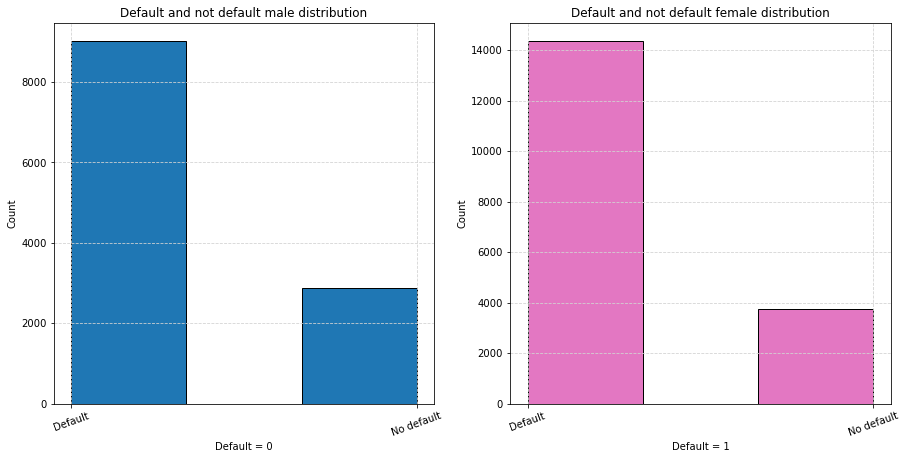

In [248]:
pylab.figure(figsize=(15,7))

pylab.subplot(1,2,1)
pylab.title('Default and not default male distribution')
pylab.grid(color='lightgrey', linestyle='--')
pylab.hist(male.values, color ='tab:blue',  edgecolor='k', bins=3)
pylab.xticks([0, 1], ['Default', 'No default'],rotation=20)
pylab.xlabel('Default = 0')
pylab.ylabel('Count')

pylab.subplot(1,2,2)
pylab.title('Default and not default female distribution')
pylab.grid(color='lightgrey', linestyle='--')
pylab.hist(female.values, color = 'tab:pink', edgecolor='k', bins=3)
pylab.xticks([0, 1], ['Default', 'No default'],rotation=20)
pylab.xlabel('Default = 1')
pylab.ylabel('Count')


pylab.show()

### Интервальные оценки долей

$$\frac1{ 1 + \frac{z^2}{n} } \left( \hat{p} + \frac{z^2}{2n} \pm z \sqrt{ \frac{ \hat{p}\left(1-\hat{p}\right)}{n} + \frac{z^2}{4n^2} } \right), \;\; z \equiv z_{1-\frac{\alpha}{2}}$$ 

In [11]:
conf_interval_male = proportion_confint(sum(male.values),male.shape[0],method = 'wilson')
conf_interval_female = proportion_confint(sum(female.values), female.shape[0],method = 'wilson')

In [12]:
print('95%% confidence interval for male default distribution: [%f, %f]' % conf_interval_male)
print('95%% confidence interval for female default distribution: [%f, %f]' % conf_interval_female)

95% confidence interval for male default distribution: [0.234061, 0.249450]
95% confidence interval for female default distribution: [0.201917, 0.213733]


Как видно с разности доверительных интервалов, а они не пересекаются, мы можем сделать вывод о том, что доля возврата кредита для мужчин и женщин отличается.

### Z-критерий для доли для двух независимых выборок (разности долей)

$$ \hat{p}_1 = \frac{a}{n_1}$$  $$ \hat{p}_2 = \frac{b}{n_2}$$


$$\text{Доверительный интервал для }p_1 - p_2\colon \;\; \hat{p}_1 - \hat{p}_2 \pm z_{1-\frac{\alpha}{2}}\sqrt{\frac{\hat{p}_1(1 - \hat{p}_1)}{n_1} + \frac{\hat{p}_2(1 - \hat{p}_2)}{n_2}}$$

$$Z-статистика: Z({X_1, X_2}) =  \frac{\hat{p}_1 - \hat{p}_2}{\sqrt{P(1 - P)(\frac{1}{n_1} + \frac{1}{n_2})}}$$
$$P = \frac{\hat{p}_1{n_1} + \hat{p}_2{n_2}}{{n_1} + {n_2}} $$

In [23]:
def proportions_diff_confint_ind(sample1, sample2, alpha = 0.05):    
    z = sc.stats.norm.ppf(1 - alpha / 2.)
    
    p1 = float(sum(sample1)) / len(sample1)
    p2 = float(sum(sample2)) / len(sample2)
    
    left_boundary = (p1 - p2) - z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    right_boundary = (p1 - p2) + z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    
    return (left_boundary, right_boundary)

In [24]:
def proportions_diff_z_stat_ind(sample1, sample2):
    n1 = len(sample1)
    n2 = len(sample2)
    
    p1 = float(sum(sample1)) / n1
    p2 = float(sum(sample2)) / n2 
    P = float(p1*n1 + p2*n2) / (n1 + n2)
    
    return (p1 - p2) / np.sqrt(P * (1 - P) * (1. / n1 + 1. / n2))

In [25]:
def proportions_diff_z_test(z_stat, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    if alternative == 'two-sided':
        return 2 * (1 - sc.stats.norm.cdf(np.abs(z_stat)))
    
    if alternative == 'less':
        return sc.stats.norm.cdf(z_stat)

    if alternative == 'greater':
        return 1 - sc.stats.norm.cdf(z_stat)

In [26]:
print("95%% confidence interval for a difference between proportions: [%f, %f]" % proportions_diff_confint_ind(male.values, female.values))

95% confidence interval for a difference between proportions: [0.024207, 0.043612]


Доверитерильний интервал для разности долей не включает ноль.

In [31]:
print("p-value: %f" % proportions_diff_z_test(proportions_diff_z_stat_ind(male.values, female.values), alternative='two-sided'))

p-value: 0.000000


In [32]:
print("p-value: %f" % proportions_diff_z_test(proportions_diff_z_stat_ind(male.values, female.values), alternative='greater'))

p-value: 0.000000


В задаче кредитног скоринга нулевая гипотеза о том, что пол не влияет на возврат кредита против двусторонней альтернативы отвергается z-критерием с достигаемым уровнем значимости 0.05. Доверительный интервал [0.024207, 0.043612]

## Задание 3

Образование (EDUCATION): Проверьте гипотезу о том, что образование не влияет на то, вернет ли человек долг.  Предложите способ наглядного представления разницы в ожидаемых и наблюдаемых значениях количества человек вернувших и не вернувших долг. Например, составьте таблицу сопряженности "образование" на "возврат долга", где значением ячейки была бы  разность между наблюдаемым и ожидаемым количеством человек.  Как бы вы предложили модифицировать таблицу так, чтобы привести значения ячеек к одному масштабу не потеряв в интерпретируемости ?  Наличие какого образования является наилучшим индикатором того, что человек  отдаст долг ? наоборт, не отдаст долг ?

In [245]:
education_default = data[data['default'] == 1].EDUCATION
education_no_default = data[data['default'] == 0].EDUCATION

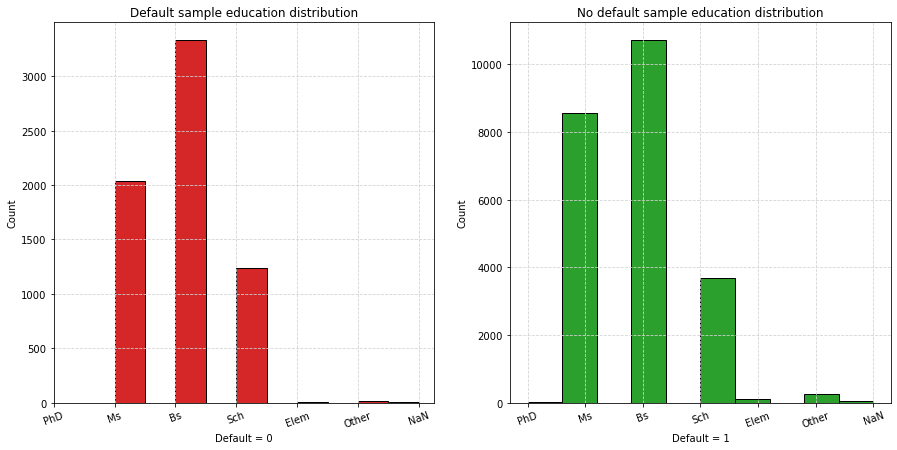

In [246]:
pylab.figure(figsize=(15,7))

pylab.subplot(1,2,1)
pylab.title('Default sample education distribution')
pylab.grid(color='lightgrey', linestyle='--')
pylab.hist(education_default.values, color ='tab:red',  edgecolor='k')
pylab.xticks([0, 1, 2, 3, 4, 5, 6], ['PhD', 'Ms', 'Bs', 'Sch', 'Elem', 'Other', 'NaN'],rotation=20)
pylab.xlabel('Default = 0')
pylab.ylabel('Count')

pylab.subplot(1,2,2)
pylab.title('No default sample education distribution')
pylab.grid(color='lightgrey', linestyle='--')
pylab.hist(education_no_default.values, color = 'tab:green', edgecolor='k')
pylab.xticks([0, 1, 2, 3, 4, 5, 6], ['PhD', 'Ms', 'Bs', 'Sch', 'Elem', 'Other', 'NaN'],rotation=20)
pylab.xlabel('Default = 1')
pylab.ylabel('Count')

pylab.show()

Распределения для тех, кто вернул кредит и не вернул сильно не отличаются. Но очевидно, что больше всего берут кредиты люди с образованием: Bs, MS, Sch. Но для нас было бы лучше посчитать долю возврата кредитов для каждой категории и отобразить графически их соотношение.

In [19]:
mean_default = []
mean_no_default = []
    
for educ in range(0,7):
    mean_default.append(data[data['EDUCATION'] == educ].default.mean())
    mean_no_default.append(1- data[data['EDUCATION'] == educ].default.mean())

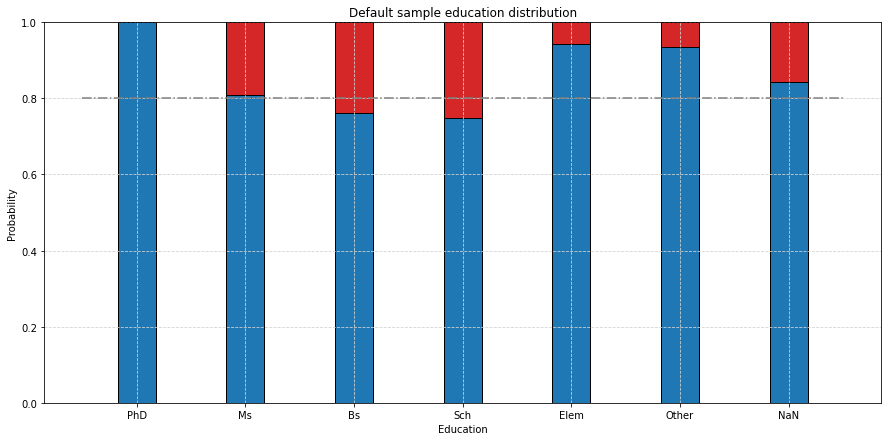

In [55]:
pylab.figure(figsize=(15,7))

pylab.title('Default sample education distribution')
pylab.grid(color='lightgrey', linestyle='--')

pylab.bar(range(0,7), mean_no_default, width=0.35, color ='tab:blue',  edgecolor='k')
pylab.bar(range(0,7), mean_default, width=0.35, color ='tab:red',  edgecolor='k', bottom=mean_no_default)
pylab.plot([-0.5,6.5],[0.8,0.8], color='tab:gray', linestyle='dashdot')

pylab.xticks([0, 1, 2, 3, 4, 5, 6], ['PhD', 'Ms', 'Bs', 'Sch', 'Elem', 'Other', 'NaN'],rotation=0)
pylab.xlabel('Education')
pylab.ylabel('Probability')

pylab.show()

In [178]:
table_real = pd.DataFrame(data=None, columns=['Education','Default_0','Default_1','Sum'])
table_real['Education'] = np.array(['PhD', 'Ms', 'Bs', 'Sch', 'Elem', 'Other', 'NaN'])

In [179]:
for educ in range(0,7):
    table_real.iloc[educ, 1] = data[(data['EDUCATION'] == educ) & (data['default'] == 0)].shape[0]
    table_real.iloc[educ, 2] = data[(data['EDUCATION'] == educ) & (data['default'] == 1)].shape[0]
    table_real.iloc[educ, 3] = table.iloc[educ, 1] + table.iloc[educ, 2]

In [180]:
table_real

,Education,Default_0,Default_1,Sum
0,PhD,14,0,14
1,Ms,8549,2036,10585
2,Bs,10700,3330,14030
3,Sch,3680,1237,4917
4,Elem,116,7,123
5,Other,262,18,280
6,NaN,43,8,51


In [173]:
table_expected = pd.DataFrame(data=None, columns=['Education','Default_0','Default_1','Sum'])
table_expected['Education'] = np.array(['PhD', 'Ms', 'Bs', 'Sch', 'Elem', 'Other', 'NaN'])

In [190]:
for educ in range(0,7):
    table_expected.iloc[educ, 1] = round((data[(data['EDUCATION'] == educ) & (data['default'] == 0)].shape[0])*mean_no_default[educ],0)
    table_expected.iloc[educ, 2] = round((data[(data['EDUCATION'] == educ) & (data['default'] == 1)].shape[0])*mean_default[educ],0)
    table_expected.iloc[educ, 3] = table_expected.iloc[educ, 1] + table_expected.iloc[educ, 2]

In [191]:
table_expected

,Education,Default_0,Default_1,Sum
0,PhD,14.0,0.0,14.0
1,Ms,6905.0,392.0,7297.0
2,Bs,8160.0,790.0,8950.0
3,Sch,2754.0,311.0,3065.0
4,Elem,109.0,0.0,109.0
5,Other,245.0,1.0,246.0
6,NaN,36.0,1.0,37.0


In [238]:
table_difference = pd.DataFrame(data=None, columns=['Education','Default_0_','Default_1','Sum'])
table_difference['Education'] = np.array(['PhD', 'Ms', 'Bs', 'Sch', 'Elem', 'Other', 'NaN'])

In [224]:
for educ in range(0,7):
    table_difference.iloc[educ, 1] = table_real.iloc[educ,1] - table_expected.iloc[educ,1]
    table_difference.iloc[educ, 2] = table_real.iloc[educ,2] - table_expected.iloc[educ,2]
    table_difference.iloc[educ, 3] = table_difference.iloc[educ, 1] + table_difference.iloc[educ, 2]

In [225]:
table_difference

,Education,Default_0,Default_1,Sum
0,PhD,0.0,0.0,0.0
1,Ms,1644.0,1644.0,3288.0
2,Bs,2540.0,2540.0,5080.0
3,Sch,926.0,926.0,1852.0
4,Elem,7.0,7.0,14.0
5,Other,17.0,17.0,34.0
6,NaN,7.0,7.0,14.0


In [228]:
def cramers_stat(matrix):
    return np.sqrt((stats.chi2_contingency(matrix)[0])/(np.sum(matrix)*(min(matrix.shape)-1)))

In [226]:
sc.stats.chi2_contingency(table_real.iloc[1:,1:3])

(159.18512540464334,
 1.4764557605044473e-32,
 5,
 array([[ 8242.50483559,  2342.49516441],
        [10925.11505369,  3104.88494631],
        [ 3828.85179751,  1088.14820249],
        [   95.77969719,    27.22030281],
        [  218.03508304,    61.96491696],
        [   39.71353298,    11.28646702]]))

In [235]:
cramers_stat(table_real.iloc[1:,1:3].to_numpy())

0.07286047087405424

Таким образом нулевая гипотеза об отсутствии связи образования и уровня дефолта уверенно отвергается на уровне значимости 0.05. Значение V Крамера равно 0.07
Очевидно, что образование должно присутствовать при оценке возврата кредита.

## Задание 4

Семейное положение (MARRIAGE): Проверьте, как связан семейный статус с индикатором дефолта: нужно предложить меру, по которой можно измерить возможную связь этих переменных и посчитать ее значение.

In [239]:
marriage_default = data[data['default'] == 1].MARRIAGE
marriage_no_default = data[data['default'] == 0].MARRIAGE

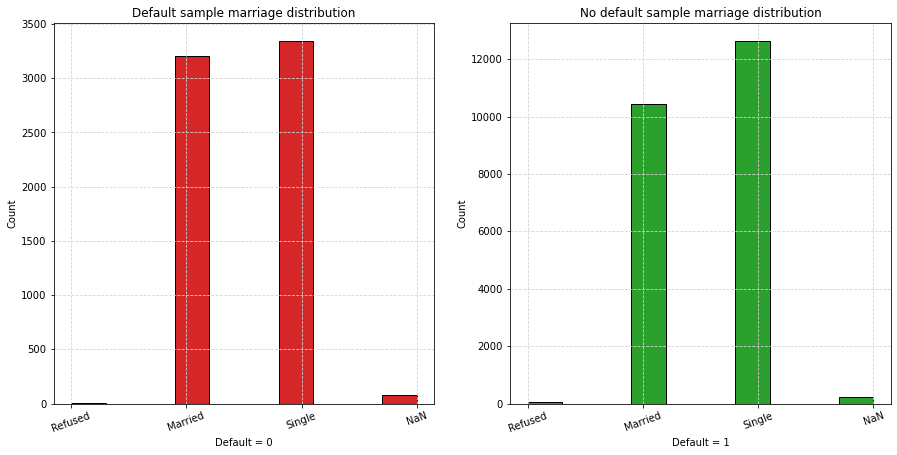

In [243]:
pylab.figure(figsize=(15,7))

pylab.subplot(1,2,1)
pylab.title('Default sample marriage distribution')
pylab.grid(color='lightgrey', linestyle='--')
pylab.hist(marriage_default.values, color ='tab:red',  edgecolor='k')
pylab.xticks([0, 1, 2, 3], ['Refused', 'Married', 'Single', 'NaN'],rotation=20)
pylab.xlabel('Default = 0')
pylab.ylabel('Count')

pylab.subplot(1,2,2)
pylab.title('No default sample marriage distribution')
pylab.grid(color='lightgrey', linestyle='--')
pylab.hist(marriage_no_default.values, color = 'tab:green', edgecolor='k')
pylab.xticks([0, 1, 2, 3], ['Refused', 'Married', 'Single', 'NaN'],rotation=20)
pylab.xlabel('Default = 1')
pylab.ylabel('Count')

pylab.show()

In [252]:
marriage_mean_default = []
marriage_mean_no_default = []
    
for mar in range(0,4):
    marriage_mean_default.append(data[data['MARRIAGE'] == mar].default.mean())
    marriage_mean_no_default.append(1-data[data['MARRIAGE'] == mar].default.mean())

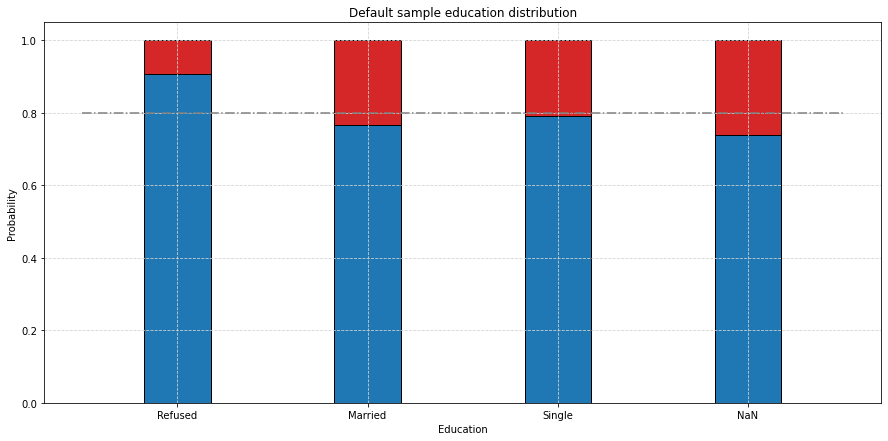

In [256]:
pylab.figure(figsize=(15,7))

pylab.title('Default sample education distribution')
pylab.grid(color='lightgrey', linestyle='--')

pylab.bar(range(0,4), marriage_mean_no_default, width=0.35, color ='tab:blue',  edgecolor='k')
pylab.bar(range(0,4), marriage_mean_default, width=0.35, color ='tab:red',  edgecolor='k', bottom=marriage_mean_no_default)
pylab.plot([-0.5,3.5],[0.8,0.8], color='tab:gray', linestyle='dashdot')

pylab.xticks([0, 1, 2, 3], ['Refused', 'Married', 'Single', 'NaN'],rotation=0)
pylab.xlabel('Education')
pylab.ylabel('Probability')

pylab.show()

In [272]:
table_marriage_real = pd.DataFrame(data=None, columns=['Marriage','Default_0','Default_1','Sum'])
table_marriage_real['Marriage'] = np.array(['Refused', 'Married', 'Single', 'NaN'])

In [273]:
table_marriage_real

,Marriage,Default_0,Default_1,Sum
0,Refused,NaN,NaN,NaN
1,Married,NaN,NaN,NaN
2,Single,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN


In [275]:
for mar in range(0,4):
    table_marriage_real.iloc[mar, 1] = data[(data['MARRIAGE'] == mar) & (data['default'] == 0)].shape[0]
    table_marriage_real.iloc[mar, 2] = data[(data['MARRIAGE'] == mar) & (data['default'] == 1)].shape[0]
    table_marriage_real.iloc[mar, 3] = table_marriage_real.iloc[mar, 1] + table_marriage_real.iloc[mar, 2]

In [276]:
table_marriage_real

,Marriage,Default_0,Default_1,Sum
0,Refused,49,5,54
1,Married,10453,3206,13659
2,Single,12623,3341,15964
3,NaN,239,84,323


In [280]:
def cramers_stat(matrix):
    return np.sqrt((stats.chi2_contingency(matrix)[0])/(np.sum(matrix)*(min(matrix.shape)-1)))

In [281]:
sc.stats.chi2_contingency(table_marriage_real.iloc[:,1:3])

(35.66239583433609,
 8.825862457577375e-08,
 3,
 array([[4.20552000e+01, 1.19448000e+01],
        [1.06376292e+04, 3.02137080e+03],
        [1.24327632e+04, 3.53123680e+03],
        [2.51552400e+02, 7.14476000e+01]]))

In [283]:
cramers_stat(table_marriage_real.iloc[:,1:3].to_numpy())

0.034478203662766466

Таким образом нулевая гипотеза об отсутствии связи замужества и уровня дефолта уверенно отвергается на уровне значимости 0.05. Значение V Крамера равно 0.0345
Очевидно, что замужество важно при оценке возврата кредита.

## Задание 5

Возраст (AGE): Относительно двух групп людей  вернувших и не вернувших кредит  проверьте следующие гипотезы:   a)  о равенстве медианных значений возрастов людей   b) о равенстве распределений  с помощью одного из подходящих непараметрических критериев проверки равенства средних.  Значимы ли полученные результаты с практической точки зрения ?

In [284]:
age_default = data[data['default'] == 1].AGE
age_no_default = data[data['default'] == 0].AGE

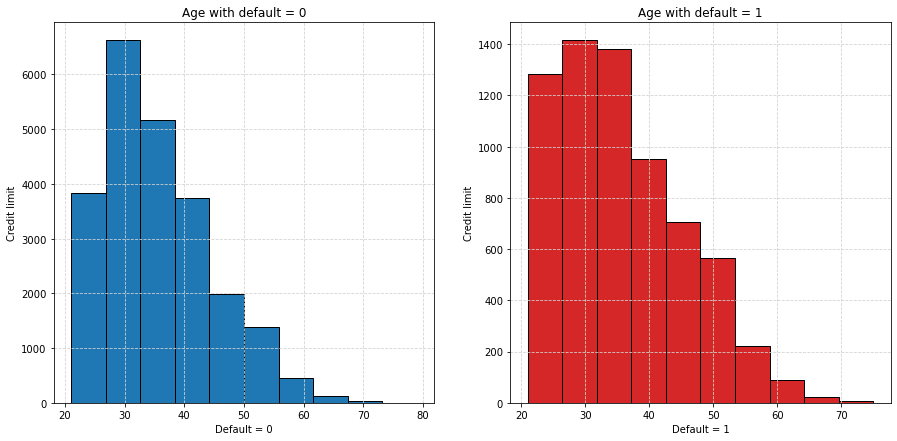

In [305]:
pylab.figure(figsize=(15,7))

pylab.subplot(1,2,1)
pylab.grid(color='lightgrey', linestyle='--')
pylab.hist(age_no_default.values, color ='tab:blue',edgecolor='k')
pylab.xlabel('Default = 0')
pylab.ylabel('Credit limit')
pylab.title('Age with default = 0')

pylab.subplot(1,2,2)
pylab.grid(color='lightgrey', linestyle='--')
pylab.hist(age_default.values, color = 'tab:red', edgecolor='k')
pylab.xlabel('Default = 1')
pylab.ylabel('Credit limit')
pylab.title('Age with default = 1')

pylab.show()

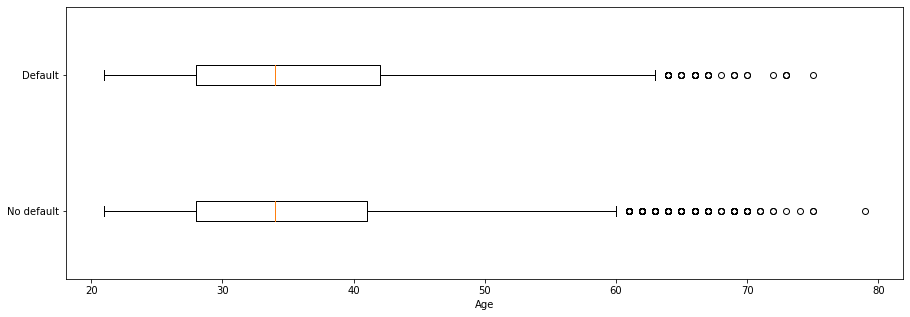

In [306]:
pylab.figure(figsize=(15,5))
pylab.boxplot([age_no_default.values,age_default.values], vert=False, labels=["No default", "Default"])
pylab.xlabel('Age')
pylab.show()

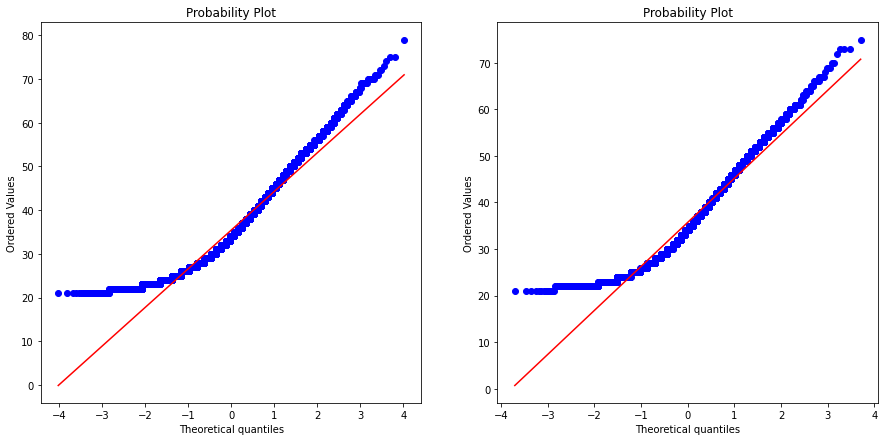

In [302]:
pylab.figure(figsize=(15,7))

pylab.subplot(1,2,1)
sc.stats.probplot(age_no_default.values, dist="norm", plot=pylab)
pylab.subplot(1,2,2)
sc.stats.probplot(age_default.values, dist="norm", plot=pylab)

pylab.show()

In [303]:
print("Shapiro-Wilk normality test, W-statistic: %f, p-value: %f" % sc.stats.shapiro(age_no_default.values))

Shapiro-Wilk normality test, W-statistic: 0.949614, p-value: 0.000000


In [304]:
print("Shapiro-Wilk normality test, W-statistic: %f, p-value: %f" % sc.stats.shapiro(age_default.values))

Shapiro-Wilk normality test, W-statistic: 0.950164, p-value: 0.000000


Q-Q plot и графики распределения подтверждают, что мы имеем дело с двумя выборками, которые имеют не нормальное распределение.
Нулевую гипотезу о нормальности распределений отвергает и критерий Шапиро-Уилка.

Так как выборки не имеют нормального распределения мы не можеи использовать параметрические критерии для распределений Стьюдента и тд. Для этой задачи может подойти использование критерия Манна-Уитни, перестановочный критерий или бутсрап.


Тогда мы расматриваем такие гипотезы:

$H_{0}: med(X_{1}) = med(X_{2})) $

$H_{0} = med(X_{1})\neq med(X_{2})) $

In [316]:
print('Age median for default = 0: {}'.format(age_no_default.median()))
print('Age median for default = 1: {}'.format(age_default.median()))

Age median for default = 0: 34.0
Age median for default = 1: 34.0


### Непараметрические критерии равенства средних: критерий Манна-Уитни

In [309]:
print('Критерий Манна-Уитни для двухвыборочной задачи с независимыми выборками: {}'.format(sc.stats.mannwhitneyu(age_no_default,age_default)))

Критерий Манна-Уитни для двухвыборочной задачи с независимыми выборками: MannwhitneyuResult(statistic=76966879.5, pvalue=0.1862517717449308)


За критерием Манна-Уитни при уровне значимости 0.05 нулевую гипотезу о равенстве медиан двух выборок отвергнуть нельзя.

### Непараметрические критерии равенства средних: перестановочный критерий для независимых выборок

$H_0\colon F_{X_1}(x) = F_{X_2}(x)$

$H_1\colon F_{X_1}(x) = F_{X_2}(x + \Delta), \Delta\neq 0$

In [317]:
print('Age mean for default = 0: {}'.format(age_no_default.mean()))
print('Age mean for default = 1: {}'.format(age_default.mean()))

Age mean for default = 0: 35.417265879130284
Age mean for default = 1: 35.72573839662447


In [310]:
def permutation_t_stat_ind(sample1, sample2):
    return np.mean(sample1) - np.mean(sample2)

In [311]:
def get_random_combinations(n1, n2, max_combinations):
    index = list(range(n1 + n2))
    indices = set([tuple(index)])
    for i in range(max_combinations - 1):
        np.random.shuffle(index)
        indices.add(tuple(index))
    return [(index[:n1], index[n1:]) for index in indices]

In [312]:
def permutation_zero_dist_ind(sample1, sample2, max_combinations = None):
    joined_sample = np.hstack((sample1, sample2))
    n1 = len(sample1)
    n = len(joined_sample)
    
    if max_combinations:
        indices = get_random_combinations(n1, len(sample2), max_combinations)
    else:
        indices = [(list(index), filter(lambda i: i not in index, range(n))) \
                    for index in itertools.combinations(range(n), n1)]
    
    distr = [joined_sample[list(i[0])].mean() - joined_sample[list(i[1])].mean() \
             for i in indices]
    return distr

In [313]:
def permutation_test(sample, mean, max_permutations = None, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    t_stat = permutation_t_stat_ind(sample, mean)
    
    zero_distr = permutation_zero_dist_ind(sample, mean, max_permutations)
    
    if alternative == 'two-sided':
        return sum([1. if abs(x) >= abs(t_stat) else 0. for x in zero_distr]) / len(zero_distr)
    
    if alternative == 'less':
        return sum([1. if x <= t_stat else 0. for x in zero_distr]) / len(zero_distr)

    if alternative == 'greater':
        return sum([1. if x >= t_stat else 0. for x in zero_distr]) / len(zero_distr)

In [320]:
print ("p-value: %f" % permutation_test(age_no_default, age_default, max_permutations = 10000))

p-value: 0.015900


### Непараметрические критерии равенства средних: бутстреп

In [321]:
def get_bootstrap_samples(data, n_samples):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

In [322]:
def stat_intervals(stat, alpha):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

In [325]:
np.random.seed(0)

age_default_bootstrap = get_bootstrap_samples(age_default.values,n_samples=1000)
age_default_boot_median = np.median(age_default_bootstrap, axis=0)

age_no_default_bootstrap = get_bootstrap_samples(age_no_default.values,n_samples=1000)
age_no_default_boot_median = np.median(age_no_default_bootstrap, axis=0)

In [326]:
print('Bootstrap default median confidance interval: {}'.format(stat_intervals(age_default_boot_median,alpha=0.05)))
print('Bootstrap no default median confidance interval: {}'.format(stat_intervals(age_no_default_boot_median,alpha=0.05)))

Bootstrap default median confidance interval: [33. 35.]
Bootstrap no default median confidance interval: [33. 35.]


Доверительные интервалы для медиан одинаковые.

### Интервальная оценка для разности медиан на бутстрепе

In [327]:
print('Difference between medians: %f' % (np.median(age_default) - np.median(age_no_default)))

Difference between medians: 0.000000


In [335]:
delta_median_scores = list(map(lambda x: x[1] - x[0], zip(age_default_boot_median, age_no_default_boot_median)))

In [337]:
stat_int = stat_intervals(delta_median_scores, 0.05)
print('95%% conf. int. for the difference between medians: [%f, %f]' % (stat_int[0], stat_int[1]))

95% conf. int. for the difference between medians: [-2.000000, 1.000000]


Доверительный интервал для разницы медиан содержит 0, разница статистически не значима. Но перестановочный критерий для средних для уровня значимости 0.05 отверг нулевую гипотезу о равенстве распределений.

Результат является практически значимым, потому что разница видна на графиках и подверждена перестановочным критерием.

## Notes

   1. Выполнение каждого пункта задания должно начинаться с графика с данными, которые вы собираетесь анализировать. Еще лучше, если вы разложите графики анализируемого фактора по переменной (default), на которую хотите изучить влияние этого фактора, и проинтерпретируете отличия в полученных распределениях.
   2. При использовании статистических критериев необходимо убедиться в том, что условия их применимости выполняются. Например, если вы видите, что данные бинарные, то не нужно применять критерий Стьюдента.
   3. При каждом использовании любого критерия необходимо указать, какая проверяется гипотеза, против какой альтернативы, чему равен достигаемый уровень значимости, принимается или отвергается нулевая гипотеза на уровне значимости 0.05. Если задача позволяет, нужно оценить размер эффекта и предположить, имеет ли этот результат практическую значимость. 
   4. Выполненное задание необходимо представить в ipython-ноутбука.